 Single Label Clause Classification Training


In [1]:
import numpy
import transformers
import datasets

print("✅ NumPy:", numpy.__version__)
print("✅ Transformers:", transformers.__version__)
print("✅ Datasets:", datasets.__version__)


✅ NumPy: 2.0.2
✅ Transformers: 4.53.0
✅ Datasets: 2.14.4


In [2]:
# ✅ Load dataset and encode labels
import pandas as pd
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("/content/clauses.csv")




label
parties                               2554
license grant                          777
cap on liability                       672
anti-assignment                        654
audit rights                           643
insurance                              560
document name                          521
agreement date                         476
expiration date                        467
governing law                          464
post-termination services              450
effective date                         447
minimum commitment                     424
revenue/profit sharing                 418
exclusivity                            410
rofr/rofo/rofn                         367
ip ownership assignment                318
non-transferable license               298
non-compete                            259
change of control                      253
termination for convenience            246
renewal term                           210
warranty duration                      176
coven

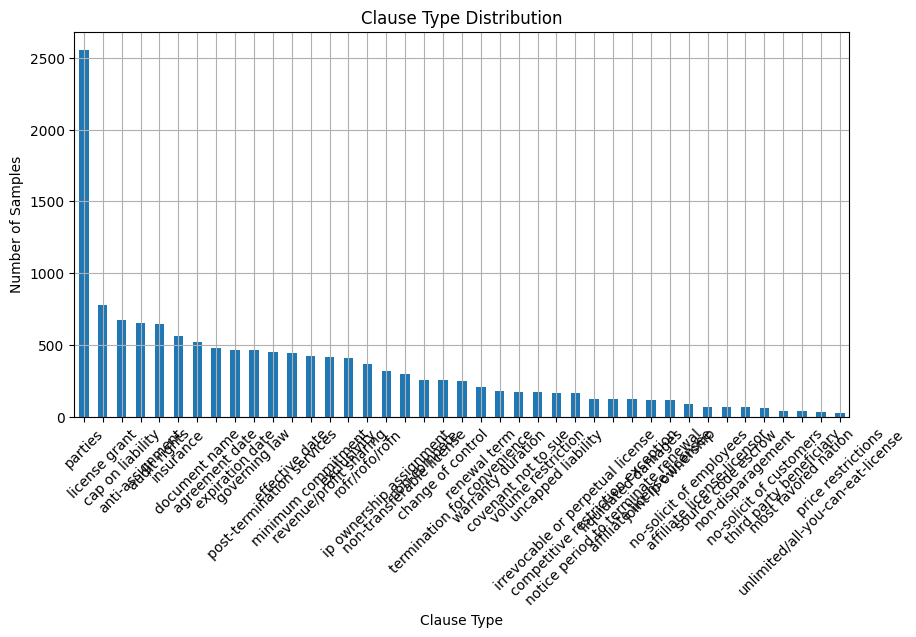

In [3]:
import matplotlib.pyplot as plt

# Count of samples per label
label_counts = df['label'].value_counts()
print(label_counts)

# Optional: plot class distribution
label_counts.plot(kind='bar', figsize=(10, 5), title='Clause Type Distribution')
plt.xlabel("Clause Type")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [4]:
import pandas as pd

df["label"] = df["label"].str.lower().str.strip()

# Select only your top 10 clause types
selected_labels = [
    "license grant", "cap on liability", "anti-assignment", "audit rights",
    "insurance", "governing law", "post-termination services",
    "minimum commitment", "revenue/profit sharing", "exclusivity"
]

df_top10 = df[df["label"].isin(selected_labels)].copy()

# Get the minimum class size (smallest available class size)
min_count = df_top10["label"].value_counts().min()
print(f"✅ Minimum samples per class: {min_count}")

# Properly group and sample
df_balanced = (
    df_top10
    .groupby("label", group_keys=False)
    .apply(lambda x: x.sample(n=min_count, random_state=42))
    .reset_index(drop=True)
)

# Double-check label counts
print("\n📊 Balanced Label Counts:")
print(df_balanced["label"].value_counts())

# Save it
df_balanced.to_csv("/content/clauses_top10_balanced.csv", index=False)
print("\n✅ File saved: clauses_top10_balanced.csv")



✅ Minimum samples per class: 410

📊 Balanced Label Counts:
label
anti-assignment              410
audit rights                 410
cap on liability             410
exclusivity                  410
governing law                410
insurance                    410
license grant                410
minimum commitment           410
post-termination services    410
revenue/profit sharing       410
Name: count, dtype: int64


/tmp/ipython-input-4-3046146087.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42))



✅ File saved: clauses_top10_balanced.csv


In [5]:
le = LabelEncoder()
df_balanced["label_id"] = le.fit_transform(df_balanced["label"])

# Optional: print mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("✅ Label mapping:\n", label_mapping)

✅ Label mapping:
 {'anti-assignment': np.int64(0), 'audit rights': np.int64(1), 'cap on liability': np.int64(2), 'exclusivity': np.int64(3), 'governing law': np.int64(4), 'insurance': np.int64(5), 'license grant': np.int64(6), 'minimum commitment': np.int64(7), 'post-termination services': np.int64(8), 'revenue/profit sharing': np.int64(9)}


In [6]:
dataset = Dataset.from_pandas(df_balanced[["clause_text", "label_id"]])
dataset = dataset.train_test_split(test_size=0.1, seed=42)

In [7]:
# ✅ Tokenization
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

def tokenize(example):
    return tokenizer(example["clause_text"], padding="max_length", truncation=True, max_length=256)

tokenized = dataset.map(tokenize,batched=True)
tokenized = tokenized.rename_column("label_id", "labels")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/3690 [00:00<?, ? examples/s]

Map:   0%|          | 0/410 [00:00<?, ? examples/s]

In [8]:
# ✅ Load model and trainer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = df_balanced["label"].nunique()
model = AutoModelForSequenceClassification.from_pretrained("nlpaueb/legal-bert-base-uncased", num_labels=num_labels)

training_args = TrainingArguments(
    output_dir="results",
    eval_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="logs",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"]
)
trainer.train()

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mihira-ad22 (siddharthamdal-is23-bmsce) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.409261
2,0.613000,0.386024


TrainOutput(global_step=924, training_loss=0.43894921339951554, metrics={'train_runtime': 438.7358, 'train_samples_per_second': 16.821, 'train_steps_per_second': 2.106, 'total_flos': 970949531381760.0, 'train_loss': 0.43894921339951554, 'epoch': 2.0})


📄 Classification Report:

                           precision    recall  f1-score   support

          anti-assignment       0.97      0.91      0.94        35
             audit rights       0.90      0.95      0.93        39
         cap on liability       0.95      0.97      0.96        36
              exclusivity       0.71      0.73      0.72        30
            governing law       0.98      0.98      0.98        44
                insurance       0.97      0.91      0.94        34
            license grant       0.79      0.77      0.78        39
       minimum commitment       0.88      0.95      0.91        39
post-termination services       0.86      0.84      0.85        58
   revenue/profit sharing       0.96      0.95      0.95        56

                 accuracy                           0.90       410
                macro avg       0.90      0.90      0.90       410
             weighted avg       0.90      0.90      0.90       410



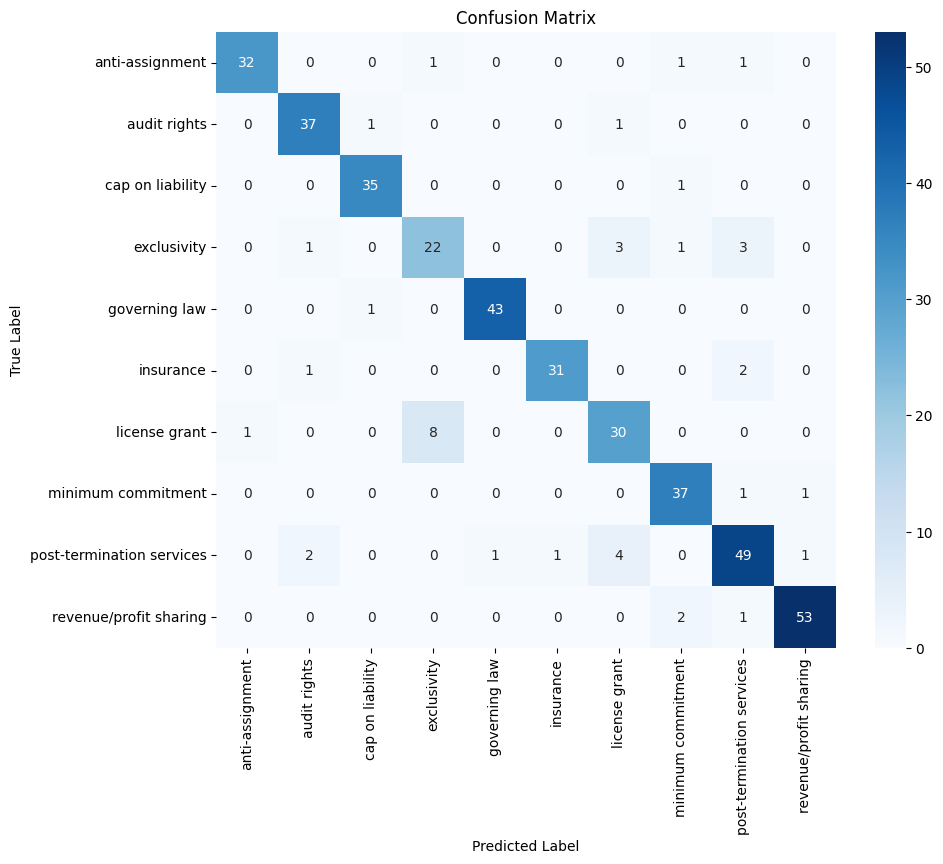

In [9]:
# ✅ Evaluate the model with classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
preds_output = trainer.predict(tokenized["test"])
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

# Print classification report
print("\n📄 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [10]:
print("Classes in test set:", set(le.inverse_transform(y_true)))


Classes in test set: {'revenue/profit sharing', 'governing law', 'insurance', 'cap on liability', 'license grant', 'audit rights', 'exclusivity', 'anti-assignment', 'minimum commitment', 'post-termination services'}


In [11]:
import pandas as pd

misclassified = pd.DataFrame({
    "text": tokenized["test"]["clause_text"],
    "true": le.inverse_transform(y_true),
    "pred": le.inverse_transform(y_pred)
})

# Show only the confused ones
confusion = misclassified[
    ((misclassified["true"] == "exclusivity") & (misclassified["pred"] == "license grant")) |
    ((misclassified["true"] == "license grant") & (misclassified["pred"] == "exclusivity"))
]

print(confusion.sample(5))

                                                  text           true  \
305  To the extent necessary to effect the foregoin...  license grant   
64   BOSCH hereby grants CLIENT the "Exclusive Dist...  license grant   
374  TL will hold exclusive worldwide              ...  license grant   
377  (a)  store or cache the Content in one or more...    exclusivity   
94   Following the signing of this Agreement, FG ag...  license grant   

              pred  
305    exclusivity  
64     exclusivity  
374    exclusivity  
377  license grant  
94     exclusivity  


In [12]:
# ✅ Save model
model.save_pretrained("clause_classifier")
tokenizer.save_pretrained("clause_classifier")

# Optional: Download zipped model
!zip -r clause_classifier.zip clause_classifier

  adding: clause_classifier/ (stored 0%)
  adding: clause_classifier/special_tokens_map.json (deflated 42%)
  adding: clause_classifier/vocab.txt (deflated 51%)
  adding: clause_classifier/tokenizer.json (deflated 71%)
  adding: clause_classifier/model.safetensors (deflated 7%)
  adding: clause_classifier/tokenizer_config.json (deflated 75%)
  adding: clause_classifier/config.json (deflated 58%)


✅ Loaded 4100 rows
⚠️ Found 171 conflicting label entries for identical clause texts


/tmp/ipython-input-1-4197946397.py:61: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


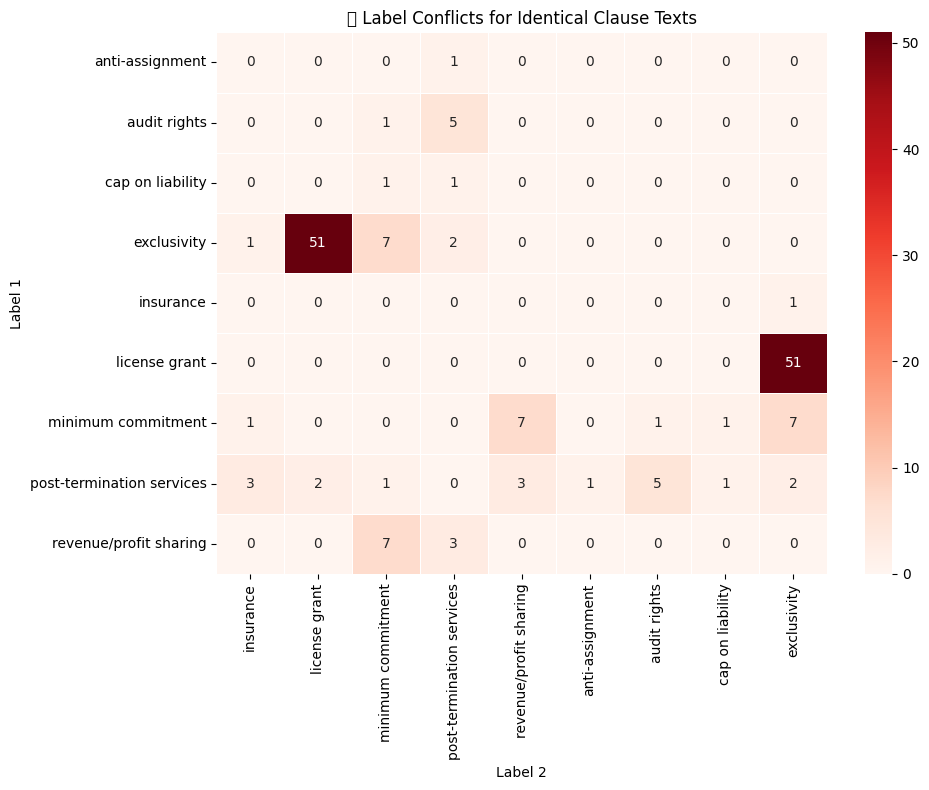

In [1]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

# ===========================
# 1. Load your dataset
# ===========================
df = pd.read_csv("/content/clauses_top10_balanced.csv")  # <-- update if needed
print(f"✅ Loaded {len(df)} rows")

# ===========================
# 2. Find identical clause_texts with conflicting labels
# ===========================
conflict_texts = df.groupby("clause_text")["label"].nunique()
conflict_texts = conflict_texts[conflict_texts > 1].index.tolist()

conflict_df = df[df["clause_text"].isin(conflict_texts)].reset_index(drop=True)
print(f"⚠️ Found {len(conflict_df)} conflicting label entries for identical clause texts")

# ===========================
# 3. Count label pair conflicts
# ===========================
pair_counts = Counter()

for text in conflict_texts:
    labels = df[df["clause_text"] == text]["label"].unique()
    for pair in combinations(sorted(labels), 2):
        pair_counts[pair] += 1

# Convert to DataFrame
pair_df = pd.DataFrame(pair_counts.items(), columns=["label_pair", "count"])
pair_df[["label_1", "label_2"]] = pd.DataFrame(pair_df["label_pair"].tolist(), index=pair_df.index)
pair_df.drop("label_pair", axis=1, inplace=True)

# Pivot to heatmap format
heatmap_data = pair_df.pivot(index="label_1", columns="label_2", values="count").fillna(0)

# Mirror the matrix for seaborn heatmap
heatmap_data_full = heatmap_data.copy()
for c in heatmap_data.columns:
    for r in heatmap_data.index:
        if c not in heatmap_data_full.index:
            heatmap_data_full.loc[c] = 0
        if r not in heatmap_data_full.columns:
            heatmap_data_full[r] = 0
        heatmap_data_full.loc[c, r] = heatmap_data.loc[r, c]

# ===========================
# 4. Visualize as heatmap
# ===========================
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_full, annot=True, fmt=".0f", cmap="Reds", linewidths=0.5)
plt.title("🔥 Label Conflicts for Identical Clause Texts")
plt.xlabel("Label 2")
plt.ylabel("Label 1")
plt.tight_layout()
plt.show()
